In [4]:
from matplotlib import pylab as plt
import time
import json

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
import sys
#import pandas
import scipy
import json
import sklearn
sys.path.append('../build')
from rascal.representations import SphericalInvariants as SOAP

from scipy.special import gamma
from scipy import integrate
from scipy.interpolate import interp1d

import ot

# N_n
def normalization(n, sigma):
    return np.sqrt( 2/(sigma**(2*n+3) *gamma(n+3/2)) )

# (S_nndash)^(-1/2)
def orthonormalization_for_n(N, b, n):
    ndash = n[:,np.newaxis]
    bdash = b[:,np.newaxis]
    Ndash = N[:,np.newaxis]
    overlap = 0.5*N*Ndash*(b+bdash)**(-0.5*(3+n+ndash))*gamma(0.5*(3+n+ndash))
    return scipy.linalg.fractional_matrix_power(overlap,-0.5)
    
def orthonnormalization_for_max_n(max_n, cutoff):
    n = np.arange(max_n)
    sigma = np.sqrt(np.hstack((1,np.arange(1,max_n)))) * cutoff / max_n
    N = normalization(n, sigma)
    b = 1/(2*sigma**2)
    return orthoonrmalization_for_n(N, b, n)

# (S_nndash)^(1/2)
def inv_orthonormalization_for_n(N, b, n):
    ndash = n[:,np.newaxis]
    bdash = b[:,np.newaxis]
    Ndash = N[:,np.newaxis]
    overlap = 0.5*N*Ndash*(b+bdash)**(-0.5*(3+n+ndash))*gamma(0.5*(3+n+ndash))
    return scipy.linalg.fractional_matrix_power(overlap,0.5)
    
def inv_orthonormalization_for_max_n(max_n, cutoff):
    n = np.arange(max_n)
    sigma = np.sqrt(np.hstack((1,np.arange(1,max_n)))) * cutoff / max_n
    N = normalization(n, sigma)
    b = 1/(2*sigma**2)
    return inv_orthonormalization_for_n(N, b, n)

# R_n(r)*r
def gto_basis_function_for_n(N, b, n, r):
    return N * r**n * np.exp(-b*r**2)

# \tilde{R}_n(r)
def orthonormalized_gto_basis_function_for_max_n(max_n, cutoff):
    n = np.arange(max_n)
    sigma = np.sqrt(np.hstack((1,np.arange(1,max_n)))) * cutoff / max_n
    N = normalization(n, sigma)
    b = 1/(2*sigma**2)
    S_m_half = orthonormalization_for_n(N, b, n)
    return lambda r : gto_basis_function_for_n(N, b, n, r).dot(S_m_half) # S_{nn'}^(-1/2) c_{i}^{n}

# \tilde{R}_n(r)
def gto_basis_function_for_max_n(max_n, cutoff):
    n = np.arange(max_n)
    sigma = np.sqrt(np.hstack((1,np.arange(1,max_n)))) * cutoff / max_n
    N = normalization(n, sigma)
    b = 1/(2*sigma**2)
    return lambda r : gto_basis_function_for_n(N, b, n, r)

# In soap we already use soap_sigma = sqrt(2)*sigma, therefore we divide by 2 for the sigma**2
def density_analytical(r,r_ij,sigma):
    radial_part = 1
    if(r_ij):
        radial_part = np.sinh(r*r_ij/(sigma**2))*(sigma**2)/(r*r_ij)
    return 8*np.pi**2*(
            radial_part * 
            np.exp(-(r**2+r_ij**2)/(2*sigma**2)) )

def density_analytical_approx(r,r_ij,sigma):
    inv_r_ij = 1
    if(r_ij):
        inv_r_ij = 1/r_ij
    return inv_r_ij * np.exp(-(r+r_ij)**2/(2*sigma**2))


# computes the [<r|X_i>]_{ir} matrix where r is on a grid
def compute_radial_expansion_density_on_grid_by_orthonormalizing_basis_set(frames,
                                            radial_basis="GTO", gaussian_sigma_type="Constant",
                                            gaussian_sigma_constant=0.4, max_radial=12, interaction_cutoff=4.5,
                                            integration_grid_size = 100):
    # We start with <nα|X_i>
    hypers = dict(soap_type="RadialSpectrum",
                  interaction_cutoff=interaction_cutoff,
                  max_radial=max_radial,
                  max_angular=0,
                  gaussian_sigma_constant=gaussian_sigma_constant,
                  gaussian_sigma_type="Constant",
                  cutoff_smooth_width=0.5,
                  radial_basis="GTO",
                  normalize=True
                  )
    soap = SOAP(**hypers)
    SM = soap.transform(frames)
    # c_n^i (envs, max_radial*nb_species)
    orthonormalized_soap_coeff = SM.get_dense_feature_matrix(soap)
    nb_envs = orthonormalized_soap_coeff.shape[0]
    nb_species = int(orthonormalized_soap_coeff.shape[1]/max_radial)
    # S^{1/2} (max_radial, max_radial)
    basis_function = orthonormalized_gto_basis_function_for_max_n(max_radial, interaction_cutoff)
    density = lambda r : orthonormalized_soap_coeff.dot( np.tile(basis_function(r), nb_species) )
    
    # [<r|X_i>]_{ir} matrix (envs, gridsize)
    integration_grid_eval = np.zeros((nb_envs, integration_grid_size))
    integration_grid = np.linspace(0,interaction_cutoff,integration_grid_size)
    for i in range(len(integration_grid)):
        integration_grid_eval[:,i] = density(integration_grid[i])
    ####
    #### comment the line below out if you want to calculate the amplited
    ####
    #integration_grid_eval = integration_grid_eval**2 # to transform the amplitude to a density
    normalizations = np.trapz(integration_grid_eval, integration_grid)
    integration_grid_eval = integration_grid_eval/normalizations[:,np.newaxis]
    return (integration_grid_eval, integration_grid)

In [5]:
def split_dataset(N, test_fraction, seed=10):
    ids = np.arange(N)
    np.random.seed(seed)
    np.random.shuffle(ids)
    Ntrain = int(N*test_fraction)
    train_ids = ids[:Ntrain]
    test_ids = ids[Ntrain:]
    return train_ids, test_ids
def get_mae(ypred,y):
    return np.mean(np.abs(ypred-y))
def get_rmse(ypred,y):
    return np.sqrt(np.mean((ypred-y)**2))
def get_sup(ypred,y):
    return np.amax(np.abs((ypred-y)))
def get_r2(y_pred,y_true):
    weight = 1
    sample_weight = None
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,dtype=np.float64)
    denominator = (weight * (y_true - np.average(
        y_true, axis=0, weights=sample_weight)) ** 2).sum(axis=0,dtype=np.float64)
    output_scores = 1 - (numerator / denominator)
    return np.mean(output_scores)

score_func = dict(
    MAE=get_mae,
    RMSE=get_rmse,
    SUP=get_sup,
    R2=get_r2,
)

def get_score(ypred,y):
    scores = {}
    for k,func in score_func.items():
        scores[k] = func(ypred,y)
    return scores

In [78]:
# \int |<r|X_i> - <r|X_j>|_2^2 dr or \int |icdf(<r|X_i>)e - icdf(<r|X_j>)|_2^2 dr
def compute_distance(positional_repr1, positional_repr2, integration_grid):
    return (positional_repr1-positional_repr2)**2

def compute_envs_complete(integration_grid_eval, integration_grid):
    nb_envs = integration_grid_eval.shape[0]
    env_distances_intg = np.zeros((nb_envs,nb_envs))
    #nb_cpus = 5
    #pool = mp.Pool(nb_cpus) #mp.cpu_count())
    print("creating indices list")
    indices = [[i,j] for i in range(nb_envs) for j in range(i)]
    env_distances = np.zeros((len(indices),len(integration_grid)))
    #print("run with", nb_cpus, "cores")
    #results = [pool.apply_async(compute_distance, args=(i, j, integration_grid_eval, integration_grid)) for i,j in indices]
    #for p in results:
    #    p.wait()        
    #pool.close()
    #results = [results[i].get() for i in range(len(results))]
    print("computing distances")
    ij = 0
    for i,j in indices:
        env_distances[ij,:] = compute_distance(integration_grid_eval[i,:], integration_grid_eval[j,:], integration_grid)
        ij = ij+1
    print("finished calculating pairwise distances")
    for i in range(nb_envs):
        env_distances_intg[i,i] = 0
    
    env_distances_intg_half = np.trapz(env_distances, integration_grid)
    print("finished integration")
    ij = 0
    for i,j in indices:
        env_distances_intg[i,j] = env_distances_intg_half[ij]
        env_distances_intg[j,i] = env_distances_intg[i,j]
        ij = ij +1
    return env_distances_intg

#TODO rename to amplitude
def analytical_amplitude_vectorize_over_neighbours(r,r_ij, soap_sigma):
    radial_part = np.ones(len(r_ij))
    #print("radial_part",radial_part)
    #print("r*np.ones(len(r_ij))!=0", r*np.ones(len(r_ij))!=0)
    neighbours = np.logical_and( r_ij!=-1, np.logical_and(r_ij!=0, r*np.ones(len(r_ij))!=0) )
    #print("neighbours",neighbours)
    radial_part[neighbours] = np.sinh(r*r_ij[neighbours]/(soap_sigma**2))*(soap_sigma**2)/(r*r_ij[neighbours])
    # centers result in center contribution, the part above is undefined for r_ij == 0 or r == 0 but converges to 1
    radial_part[r_ij==0] = 1
    # non neighbours result in 0 contribution
    radial_part[r_ij==-1] = 0
    #print("radial_part after", radial_part)
    return ( radial_part * 
            np.exp(-(r**2+r_ij**2)/(2*soap_sigma**2)) )

def compute_analytical_amplitude_with_neighbour_contribution_for_envs(atomic_structure, grid, cutoff, soap_sigma=0.5):
    nb_centers = len(atomic_structure)
    dist = atomic_structure.get_all_distances()
    dist[dist>cutoff] = -1
    #print("dist", dist)
    grid_eval = np.zeros((nb_centers,len(grid)))
    #print(density_analytical_vec(0, dist[0,:], sigma))
    for i in range(nb_centers):
        grid_eval[i,:] = np.array([np.sum(analytical_amplitude_vectorize_over_neighbours(r, dist[i,:], soap_sigma)) for r in grid])
    return grid_eval

def compute_analytical_amplitude_with_neighbour_contribution_for_structures(structures, grid, cutoff, soap_sigma=0.5):
    grid_size = len(grid)
    structure_indices = np.hstack((0,np.cumsum([structure.get_number_of_atoms() for structure in structures])))
    nb_structures = len(structure_indices)
    nb_total_envs = structure_indices[-1]    
    amplitude_of_structures_on_grid = np.zeros((nb_total_envs, grid_size))
    for i in range(nb_structures-1):        
        amplitude_of_structures_on_grid[structure_indices[i]:structure_indices[i+1],:] = \
             compute_analytical_amplitude_with_neighbour_contribution_for_envs(structures[i], grid, cutoff, soap_sigma)
    return amplitude_of_structures_on_grid

class PySOAPKernel(object):
    def __init__(self, frames, radial_basis="GTO", gaussian_sigma_type="Constant",
                                            gaussian_sigma_constant=0.4, max_radial=12, interaction_cutoff=4.5):
        # We start with <nα|X_i>
        hypers = dict(soap_type="RadialSpectrum",
                      interaction_cutoff=interaction_cutoff,
                      max_radial=max_radial,
                      max_angular=0,
                      gaussian_sigma_constant=gaussian_sigma_constant,
                      gaussian_sigma_type="Constant",
                      cutoff_smooth_width=0.5,
                      normalize=True
                      )
        soap = SOAP(**hypers)
        SM = soap.transform(frames)
        # c_n^i (envs, max_radial*nb_species)
        self.orthonormalized_soap_coeff = SM.get_dense_feature_matrix(soap)
        self.kernel_function = lambda distances : 1-distances/2
    
    def compute_distance_complete(self):
        # squared distance
        self.distance_complete = self.orthonormalized_soap_coeff.dot(self.orthonormalized_soap_coeff.T)
                          
    def compute_kernel_complete(self):
        self.kernel_complete = self.kernel_function(self.distance_complete)
        self.kernel_complete /= np.linalg.norm(self.kernel_complete)

    def slice_kernel_complete_indices(self, ids1, ids2):
        indices = np.array(np.meshgrid(ids1,ids2)).T.reshape(-1,2)
        indices_x = indices[:,0]
        indices_y = indices[:,1]
        return self.kernel_complete[indices_x, indices_y].reshape(len(ids1),len(ids2))
        
    def compute_weights(self, envs_train_ids, train_labels, Lambda=10, jitter=1e-8):        
        kernel_train = self.slice_kernel_complete_indices(envs_train_ids, envs_train_ids)
        # adjust the kernel so that it is properly scaled
        delta = np.std(train_labels) / np.mean(self.kernel_complete.diagonal())
        kernel_train[np.diag_indices_from(kernel_train)] += Lambda**2 / delta **2 + jitter

        # train the krr model, w = (K_train + lambda*I)^(-1)y
        self.weights = np.linalg.solve(kernel_train, train_labels)
        
    def predict(self, structures_train_ids, structures_test_ids):
        # train the krr model, w = (K_train + lambda*I)^(-1)y
        kernel_test = self.slice_kernel_complete_indices(structures_train_ids, structures_test_ids)
        return np.dot(self.weights, kernel_test)



class WassersteinKernelICDF(object):
    def __init__(self, frames, icdf=False, sigma=0.5, zeta=2, grid_size=100, cutoff=4.5, soap_sigma=0.4):
        self.sigma = sigma
        self.zeta = zeta
        self.kernel_function = lambda distances : 1-distances/2
        #self.kernel_function = lambda distances : np.power(np.cos(distances/np.max(distances)), self.zeta)
        # integration_grid_eval_diff.shape (nb_struc, nb_grid_points)
        #self.integration_grid_eval, self.integration_grid = compute_radial_expansion_density_on_grid_by_orthonormalizing_basis_set(frames)
        
        self.integration_grid = np.linspace(0,cutoff,grid_size)
        self.integration_grid_eval = compute_analytical_amplitude_with_neighbour_contribution_for_structures(frames, grid, cutoff, soap_sigma)
        #distance_squared = compute_envs_complete(self.integration_grid_eval, self.integration_grid)

        if (icdf):
            # cumulative sum method
            integration_grid_eval_sorted = np.cumsum(self.integration_grid_eval, axis=1)
            # normalize it
            integration_grid_eval_sorted = integration_grid_eval_sorted/integration_grid_eval_sorted[:,-2:-1]
            
            #cdf_manual = np.zeros(self.integration_grid_eval.shape[0], len(self.integration_grid))
            #for i in range(2,len(self.integration_grid)+1):
            #    cdf_manual[:,i-1] = np.trapz(self.integration_grid_eval[:,0:i], model2.integration_grid[0:i])

            interpolators = [interp1d(integration_grid_eval_sorted[i,:],self.integration_grid) for i in range(integration_grid_eval_sorted.shape[0])]
            # TODO nb_grid_points is here hardcoded here
            intp_range_min = np.max(integration_grid_eval_sorted[:,0])
            intp_range_max = np.min(integration_grid_eval_sorted[:,-1])
            print("intp_range",intp_range_min,intp_range_max)
            self.integration_grid = np.linspace(intp_range_min,intp_range_max,100)
            for i in range(integration_grid_eval_sorted.shape[0]): # nb_envs
                self.integration_grid_eval[i] = interpolators[i](self.integration_grid)
        self.weights = None
        self.nb_structures = len(frames)
                    
    def compute_distance_complete(self):
        self.distance_complete = compute_envs_complete(self.integration_grid_eval, self.integration_grid)
                          
    def compute_kernel_complete(self):
        self.kernel_complete = self.kernel_function(self.distance_complete)
        self.kernel_complete /= np.linalg.norm(self.kernel_complete)

    def slice_kernel_complete_indices(self, ids1, ids2):
        indices = np.array(np.meshgrid(ids1,ids2)).T.reshape(-1,2)
        indices_x = indices[:,0]
        indices_y = indices[:,1]
        return self.kernel_complete[indices_x, indices_y].reshape(len(ids1),len(ids2))
        
    def compute_weights(self, envs_train_ids, train_labels, Lambda=10, jitter=1e-8):        
        kernel_train = self.slice_kernel_complete_indices(envs_train_ids, envs_train_ids)
        # adjust the kernel so that it is properly scaled
        delta = np.std(train_labels) / np.mean(self.kernel_complete.diagonal())
        kernel_train[np.diag_indices_from(kernel_train)] += Lambda**2 / delta **2 + jitter

        # train the krr model, w = (K_train + lambda*I)^(-1)y
        self.weights = np.linalg.solve(kernel_train, train_labels)
        
    def predict(self, structures_train_ids, structures_test_ids):
        # train the krr model, w = (K_train + lambda*I)^(-1)y
        kernel_test = self.slice_kernel_complete_indices(structures_train_ids, structures_test_ids)
        return np.dot(self.weights, kernel_test)
    
class WassersteinKernelOT:
    '''Wasserstein distance matrix used as a kernel'''
    def __init__(self, frames, sigma=0.5, kernel_type='Atom', grid_size=100, gaussian_sigma_constant=0.4, max_radial=12, interaction_cutoff=4.5):
        assert kernel_type in ['Atom', 'Structure']
        self.target = kernel_type
        self.grid_size = grid_size
        self.cutoff = interaction_cutoff
        grid = np.linspace(0, self.cutoff, self.grid_size)
        self.sigma = sigma
        self.gaussian_sigma_constant = gaussian_sigma_constant
        self.kernel_function = lambda distances : np.exp(-0.5*np.sqrt(distances)/self.sigma**2)
        # initialize the cost matrix as the distances between grid points
        # for grid_size=4  |0 1 2 3|l
        #                  |1 0 1 2|
        #                  |2 1 0 1|
        #                  |3 2 1 0|
        distances = np.arange(self.grid_size, dtype='double')
        self.cost = np.zeros((self.grid_size, self.grid_size), dtype='double')
        for i in range(self.grid_size):
            self.cost[i, i:] = distances[:self.grid_size - i]
            self.cost[i:, i] = distances[:self.grid_size - i]
        self.cost = self.cost*(grid[1]-grid[0])
            
        hypers = dict(soap_type="RadialSpectrum",
              interaction_cutoff=interaction_cutoff,
              max_radial=max_radial,
              max_angular=0,
              gaussian_sigma_constant=gaussian_sigma_constant,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=True
              )
        soap = SOAP(**hypers)
        SM = soap.transform(frames)
        # c_n^i (envs, max_radial*nb_species)
        orthonormalized_soap_coeff = SM.get_dense_feature_matrix(soap)
        
        self.max_radial = max_radial
        #self.atom_density_eval_on_grid = self._position_representation(orthonormalized_soap_coeff, grid)
        self.atom_density_eval_on_grid = compute_analytical_amplitude_with_neighbour_contribution_for_structures(frames, grid, interaction_cutoff, gaussian_sigma_constant)


    def compute_distance_complete(self):
        n_train = self.atom_density_eval_on_grid.shape[0]
        self.distance_complete = np.zeros((n_train, n_train), dtype='double')
        
        # Attempt to parallelize it, not finished
        #train_ij = [(self.atom_density_eval_on_grid[i,:],self.atom_density_eval_on_grid[j,:]) for i
        #print("run with", nb_cpus, "cores")
        #train_i = np.array(self.atom_density_eval_on_grid[i, :])
        #train_j = np.array(self.atom_density_eval_on_grid[j, :])
        #results = [pool.apply_async(compute_distance, args=(i, j, integration_grid_eval, integration_grid)) for i,j in indices]
        #for p in results:
        #    p.wait()        
        #pool.close()
        #results = [results[i].get() for i in range(len(results))]
        #pool.apply_async(ot.emd2, args=(train_i, train_j, self.cost))
        
        indices = [[i,j] for i in range(n_train) for j in range(i)]        
        # upper triangle iteration
        for ind in range(len(indices)):
            i = indices[ind][0]
            j = indices[ind][1]
            train_i = np.array(self.atom_density_eval_on_grid[i, :])
            train_j = np.array(self.atom_density_eval_on_grid[j, :])
            self.distance_complete[i,j] = ot.emd2(train_i, train_j, self.cost)
            #self.distance_complete[i,j] = ot.emd2_1d(train_i, train_j, metric='minkowski',p=2)
            if (i % 100 == 0) and  (j==0):
                print("If zero, something is probably wrong", self.distance_complete[i,j])
                print(f'at step {i}')
        
        for i in range(n_train):
            self.distance_complete[i,i] = 0
            for j in range(i):
                self.distance_complete[j, i] = self.distance_complete[i, j]
                

    def _position_representation(self, features, grid):        
        nb_species = int(features.shape[1] / self.max_radial)
        basis_function = orthonormalized_gto_basis_function_for_max_n(self.max_radial, self.cutoff)
        repr = np.array([features.dot(np.tile(basis_function(r), nb_species)) for r in grid])
        repr = repr**2
        if self.target == 'Atom':
            # Normalize the distribution to ensure the sum is 1
            #repr /= repr.sum(axis=0)
            repr /= repr.sum(axis=0)
            # more exact than above method
            #repr /= np.trapz(repr.T, grid)[np.newaxis,:]
            #return repr
            return repr.T
        else:
            assert self.target == 'Structure'
            raise Exception('unimplemented')
            
    def compute_kernel_complete(self):
        self.kernel_complete = self.kernel_function(self.distance_complete)
        self.kernel_complete /= np.linalg.norm(self.kernel_complete)

    def slice_kernel_complete_indices(self, ids1, ids2):
        indices = np.array(np.meshgrid(ids1,ids2)).T.reshape(-1,2)
        indices_x = indices[:,0]
        indices_y = indices[:,1]
        return self.kernel_complete[indices_x, indices_y].reshape(len(ids1),len(ids2))
        
    def compute_weights(self, envs_train_ids, train_labels, Lambda=10, jitter=1e-8):        
        kernel_train = self.slice_kernel_complete_indices(envs_train_ids, envs_train_ids)
        # adjust the kernel so that it is properly scaled
        delta = np.std(train_labels) / np.mean(self.kernel_complete.diagonal())
        kernel_train[np.diag_indices_from(kernel_train)] += Lambda**2 / delta **2 + jitter

        # train the krr model, w = (K_train + lambda*I)^(-1)y
        self.weights = np.linalg.solve(kernel_train, train_labels)
        
    def predict(self, structures_train_ids, structures_test_ids):
        # train the krr model, w = (K_train + lambda*I)^(-1)y
        kernel_test = self.slice_kernel_complete_indices(structures_train_ids, structures_test_ids)
        return np.dot(self.weights, kernel_test)


In [47]:
frames = read('./data/CSD-500.xyz','0:5')
# wraps the structures into the unit cell
for i in range(len(frames)):
    frames[i].wrap(eps=1e-11)
print("number of envs", sum([frame.get_number_of_atoms() for frame in frames]))

# compatutational heavy compute
model_l2 = WassersteinKernelICDF(frames)
model_l2.compute_distance_complete()
model_l2.compute_kernel_complete()

number of envs 678
creating indices list
computing distances
finished calculating pairwise distances
finished integration


In [82]:
import ase.neighborlist
frames = read('./data/h2.json',':')
# wraps the structures into the unit cell
for i in range(len(frames)):
    frames[i].wrap(eps=1e-11)
print("number of envs", sum([frame.get_number_of_atoms() for frame in frames]))
h2 = frames[0]
h2.get_positions()
cutoff_per_atom = h2.get_number_of_atoms()*[0.000005]
nl = ase.neighborlist.NeighborList(cutoff_per_atom, self_interaction=True)
nl.update(h2)
indices, offsets = nl.get_neighbors(0)
print(indices)

number of envs 2
[0 1]


array([[0. , 0. , 0. ],
       [0.5, 0. , 0. ]])

In [79]:
# Computes the distances

# data
frames = read('./data/CSD-500.xyz','0:1')
# wraps the structures into the unit cell
for i in range(len(frames)):
    frames[i].wrap(eps=1e-11)
print("number of envs", sum([frame.get_number_of_atoms() for frame in frames]))

# compatutational heavy compute
model_l2 = WassersteinKernelICDF(frames)
model_l2.compute_distance_complete()
model_l2.compute_kernel_complete()

model_soap = PySOAPKernel(frames)
model_soap.compute_distance_complete()
model_soap.compute_kernel_complete()

model_wasserstein_icdf = WassersteinKernelICDF(frames, icdf=True)
model_wasserstein_icdf.compute_distance_complete()
model_wasserstein_icdf.compute_kernel_complete()

#model_wasserstein_ot = WassersteinKernelOT(frames)
#model_wasserstein_ot.compute_distance_complete()
#model_wasserstein_ot.compute_kernel_complete()

number of envs 192
creating indices list
computing distances
finished calculating pairwise distances
finished integration
intp_range 0.07856137755728848 1.0000002829447765
creating indices list
computing distances
finished calculating pairwise distances
finished integration


In [80]:
# Computes the weights and evaluates them

def evaluate(model, max_nb_frames, chem_shifts, scores):
    print("max_nb_frames", max_nb_frames)
    train_ids, test_ids = split_dataset(max_nb_frames, 0.8)
    # split the train ids into 0.2 cumluative chunks and train on each chunk
    nbs_trains_ids = list(range(80,(len(train_ids)+1),int(0.2*len(train_ids))))
    print("nbs_trains_ids",nbs_trains_ids)
    for nb_trains_ids in nbs_trains_ids:
        train_ids_this = train_ids[0:nb_trains_ids]
        model.compute_weights(train_ids_this, chem_shifts[train_ids_this])
        print("weights computed")
        pred = model.predict(train_ids_this, test_ids)
        scores.append(get_score(pred, chem_shifts[test_ids]))
    return nbs_trains_ids
    
# exp/rbf/cos

# for this case the POT linear program and icdf method works similar
#model_l2.kernel_function = lambda distances : np.exp(-0.5*distances/0.5**2)
#model_wasserstein_icdf.kernel_function = lambda distances : np.exp(-0.5*distances/0.5**2)
#model_wasserstein_ot.kernel_function = lambda distances : np.exp(-0.5*distances/0.5**2)

# here the difference is more present due to the sqrt, but this would be the way to use it
#model_l2.kernel_function = lambda distances : np.exp(-0.5*np.sqrt(distances)/0.5**2)
#model_wasserstein_icdf.kernel_function = lambda distances : np.exp(-0.5*np.sqrt(distances)/0.5**2)
#model_wasserstein_ot.kernel_function = lambda distances : np.exp(-0.5*np.sqrt(distances)/0.5**2)

# plain 1-D**2/
model_l2.kernel_function = lambda distances : 1-distances/2
model_wasserstein_icdf.kernel_function = lambda distances : 1-distances/2
model_soap.kernel_function = lambda distances : 1-distances/2
#model_wasserstein_ot.kernel_function = lambda distances : 1-distances**2/2 # because the ot takes square

model_l2.compute_kernel_complete()
model_wasserstein_icdf.compute_kernel_complete()
model_soap.compute_kernel_complete()
#model_wasserstein_ot.compute_kernel_complete()

# labels
chem_shifts = []
for frame in frames:
    chem_shifts.append(frame.arrays['CS'])
chem_shifts_atoms = np.concatenate(chem_shifts, axis=0)
chem_shifts_atoms_1 = chem_shifts_atoms[:,0]

scores_l2 = []
scores_wasserstein_icdf = []
scores_model_soap = []
scores_wasserstein_ot = []
max_nb_frames = sum([frame.get_number_of_atoms() for frame in frames])

nbs_frames = evaluate(model_l2, max_nb_frames, chem_shifts_atoms_1, scores_l2)
evaluate(model_wasserstein_icdf, max_nb_frames, chem_shifts_atoms_1, scores_wasserstein_icdf)
evaluate(model_soap, max_nb_frames, chem_shifts_atoms_1, scores_model_soap)
#evaluate(model_wasserstein_ot, max_nb_frames, chem_shifts_atoms_1, scores_wasserstein_ot)

max_nb_frames 192
nbs_trains_ids [80, 110, 140]
weights computed
weights computed
weights computed
max_nb_frames 192
nbs_trains_ids [80, 110, 140]
weights computed
weights computed
weights computed
max_nb_frames 192
nbs_trains_ids [80, 110, 140]
weights computed
weights computed
weights computed


[80, 110, 140]

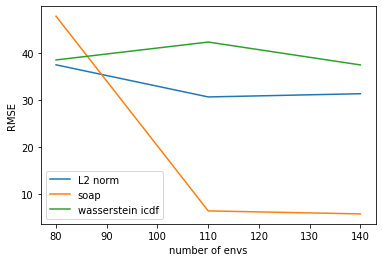

In [82]:
rmse_l2 = [score['RMSE'] for score in scores_l2]
rmse_wasserstein_icdf = [score['RMSE'] for score in scores_wasserstein_icdf]
rmse_model_soap = [score['RMSE'] for score in scores_model_soap]
#rmse_wasserstein_ot = [score['RMSE'] for score in scores_wasserstein_ot]
plt.plot(nbs_frames, rmse_l2, label='L2 norm')
plt.plot(nbs_frames, rmse_model_soap, label='soap')
plt.plot(nbs_frames, rmse_wasserstein_icdf, label='wasserstein icdf')
#plt.plot(nbs_frames, rmse_wasserstein_ot, label='wasserstein ot')
plt.xlabel("number of envs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [84]:
soap_k = model_soap.kernel_complete
soap_k = soap_k/np.linalg.norm(soap_k)
l2_k = model_l2.kernel_complete
l2_k = l2_k/np.linalg.norm(l2_k)
diff = np.abs(soap_k - l2_k)
print("mean error", np.mean(diff))
print("max error", np.max(diff))
diff[diff>1e-1] = 1
diff[diff<=1e-1] = 0
print(np.sum(diff))
print(diff.shape[0] * diff.shape[1])

mean error 0.00042396965708393
max error 0.0010097954660489026
0.0
36864


In [100]:
rand_k = np.random.rand(*l2_k.shape)
rand_k /= np.linalg.norm(rand_k)
diff = np.abs(rand_k - l2_k)
print("mean error", np.mean(diff))
print("max error", np.max(diff))

mean error 0.0023039164539099544
max error 0.005226510913305406


In [97]:
diff = np.abs(model_wasserstein_icdf.distance_complete - model_wasserstein_ot.distance_complete)
print("mean error", np.mean(diff))
print("max error", np.max(diff))
diff[diff>1e-1] = 1
diff[diff<=1e-1] = 0
print(np.sum(diff))
print(diff.shape[0] * diff.shape[1])

NameError: name 'model_wasserstein_ot' is not defined

In [40]:
soap_sigma=0.4
cutoff=4.5
max_radial=15
grid_size=100

hypers = dict(soap_type="RadialSpectrum",
              interaction_cutoff=cutoff,
              max_radial=max_radial,
              max_angular=0,
              gaussian_sigma_constant=soap_sigma,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              radial_basis="GTO",
              normalize=True       
              )
soap = SOAP(**hypers)

#frames = read('./data/CSD-500.xyz','0:2')
frames = read('./data/h2.json',':')

# wraps the structures into the unit cell
for i in range(len(frames)):
    frames[i].wrap(eps=1e-11)
print("number of envs", sum([frame.get_number_of_atoms() for frame in frames]))

SM = soap.transform(frames)
# c_n^i (envs, max_radial*nb_species)
orthonormalized_soap_coeff = SM.get_dense_feature_matrix(soap)

grid = np.linspace(0,cutoff,grid_size)
analytical_amplitude_on_grid = compute_analytical_amplitude_with_neighbour_contribution_for_structures(frames, grid_size, cutoff, soap_sigma)
distance_squared = compute_envs_complete(analytical_amplitude_on_grid, grid)
kernel = 1 - distance_squared/2
kernel_standard = orthonormalized_soap_coeff.dot(orthonormalized_soap_coeff.T)

number of envs 2
creating indices list
computing distances
finished calculating pairwise distances
finished integration


In [41]:
kernel = kernel/np.linalg.norm(kernel)
kernel_standard = kernel_standard/np.linalg.norm(kernel_standard)

In [42]:
diff = np.abs(kernel-kernel_standard)
print(np.max(diff))
print(np.mean(diff))

0.0
0.0


In [43]:
print(kernel_standard)

[[0.5 0.5]
 [0.5 0.5]]
